# Spark + Airflow + MLflow: Orquestación de Pipelines ML

## Objetivos
- Crear un pipeline de datos con Apache Spark
- Orquestar el pipeline con Apache Airflow
- Trackear experimentos y métricas con MLflow
- Implementar un flujo end-to-end de ML

## Conceptos Clave
- **Spark**: Motor de procesamiento distribuido
- **Airflow**: Plataforma de orquestación de workflows
- **MLflow**: Plataforma de gestión del ciclo de vida ML

## Arquitectura del Pipeline
```
Airflow DAG
    ↓
1. Ingesta de datos (Spark)
    ↓
2. Transformación (Spark)
    ↓
3. Feature Engineering (Spark)
    ↓
4. Entrenamiento de modelo (Spark ML + MLflow)
    ↓
5. Evaluación y registro (MLflow)
```

## 1. Setup e Importaciones

In [70]:
# Importaciones necesarias
import os
import sys
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')



# Spark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, mean, stddev, log1p
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType

# Spark ML
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# MLflow
import mlflow
import mlflow.spark
from mlflow.tracking import MlflowClient

# Airflow (para definir DAGs)
from airflow import DAG
from airflow.operators.python import PythonOperator
from airflow.providers.apache.spark.operators.spark_submit import SparkSubmitOperator

# Utilidades
import pandas as pd
import numpy as np

print("✓ Importaciones completadas")

✓ Importaciones completadas


## 2. Configuración de Spark y MLflow

In [71]:

local_registry = f"file://{os.getcwd()}/mlruns"
mlflow.set_tracking_uri(local_registry)

# 2. Configurar el experimento
experiment_name = "spark-airflow-pipeline"
mlflow.set_experiment(experiment_name)

print(f"✓ Spark version: {spark.version}")
print(f"✓ MLflow tracking URI: {mlflow.get_tracking_uri()}")

# Verificación segura del experimento
exp = mlflow.get_experiment_by_name(experiment_name)
if exp:
    print(f"✓ MLflow experiment: {exp.name} (ID: {exp.experiment_id})")

✓ Spark version: 4.1.0
✓ MLflow tracking URI: file:///Users/yusefgonzalez/proyectos/arquitecturas/spark/notebooks/mlruns
✓ MLflow experiment: spark-airflow-pipeline (ID: 410152290516762576)


## 3. Simulación de DAG de Airflow

En un entorno real, este DAG estaría en `airflow/dags/`. Aquí lo simulamos para propósitos educativos.

In [72]:
# Definición del DAG (esto normalmente va en airflow/dags/spark_ml_pipeline.py)

default_args = {
    'owner': 'yusef',
    'depends_on_past': False,
    'start_date': datetime(2024, 1, 1),
    'email_on_failure': False,
    'email_on_retry': False,
    'retries': 1,
    'retry_delay': timedelta(minutes=5),
}

# Estructura del DAG
dag_structure = """
DAG: spark_ml_pipeline
├── Task 1: ingest_data
├── Task 2: transform_data
├── Task 3: feature_engineering
├── Task 4: train_model
└── Task 5: evaluate_model
"""

print(dag_structure)
print("\nNota: En producción, este DAG se ejecutaría en Airflow")
print("Aquí ejecutaremos cada tarea manualmente para demostración")


DAG: spark_ml_pipeline
├── Task 1: ingest_data
├── Task 2: transform_data
├── Task 3: feature_engineering
├── Task 4: train_model
└── Task 5: evaluate_model


Nota: En producción, este DAG se ejecutaría en Airflow
Aquí ejecutaremos cada tarea manualmente para demostración


## 4. Task 1: Ingesta de Datos

Generamos datos sintéticos que simulan transacciones de clientes para detectar fraude.

In [73]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
import mlflow

# Definir el constructor de la sesión
spark = SparkSession.builder \
    .appName("Airflow-MLflow-Pipeline") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print("✓ Spark Session inicializada")

✓ Spark Session inicializada


In [74]:
def ingest_data():
    """Task 1: Ingesta de datos usando Spark"""
    # Verificación de seguridad
    global spark
    if 'spark' not in globals() or spark._jsc is None:
        print("⚠ Spark no estaba activo. Reiniciando sesión...")
        spark = SparkSession.builder.getOrCreate()

    print("[Task 1] Iniciando ingesta de datos...")
    
    # Generar datos sintéticos
    np.random.seed(42)
    n_samples = 10000
    
    data = {
        'transaction_id': range(n_samples),
        'amount': np.random.exponential(100, n_samples),
        'merchant_category': np.random.choice(['retail', 'online', 'restaurant', 'travel'], n_samples),
        'transaction_hour': np.random.randint(0, 24, n_samples),
        'customer_age': np.random.randint(18, 80, n_samples),
        'is_international': np.random.choice([0, 1], n_samples, p=[0.9, 0.1]),
        'num_previous_transactions': np.random.randint(0, 100, n_samples),
        'is_fraud': np.random.choice([0, 1], n_samples, p=[0.95, 0.05])  # 5% fraude
    }
    
    # Crear DataFrame de Spark
    df = spark.createDataFrame(pd.DataFrame(data))
    
    print(f"✓ Datos ingestados: {df.count()} registros")
    print(f"✓ Columnas: {df.columns}")
    
    return df

# Ejecutar Task 1
raw_df = ingest_data()
raw_df.show(5)
raw_df.printSchema()

[Task 1] Iniciando ingesta de datos...
✓ Datos ingestados: 10000 registros
✓ Columnas: ['transaction_id', 'amount', 'merchant_category', 'transaction_hour', 'customer_age', 'is_international', 'num_previous_transactions', 'is_fraud']
+--------------+------------------+-----------------+----------------+------------+----------------+-------------------------+--------+
|transaction_id|            amount|merchant_category|transaction_hour|customer_age|is_international|num_previous_transactions|is_fraud|
+--------------+------------------+-----------------+----------------+------------+----------------+-------------------------+--------+
|             0| 46.92680899768591|       restaurant|              21|          25|               0|                       39|       0|
|             1| 301.0121430917521|           travel|              12|          60|               0|                        1|       0|
|             2|131.67456935454493|           travel|              15|          42|   

## 5. Task 2: Transformación de Datos

In [75]:
# 2. Configuración de MLflow (Local para evitar error 403)
# Forzamos el tracking local en la carpeta del proyecto
mlflow.set_tracking_uri(f"file://{os.getcwd()}/mlruns")
mlflow.set_experiment("spark-airflow-pipeline")

def transform_data(df):
    """Task 2: Transformación y limpieza de datos con tracking de MLflow"""
    print("\n[Task 2] Iniciando transformación de datos...")
    
    # Iniciamos un run de MLflow para esta tarea específica
    with mlflow.start_run(run_name="Data_Transformation"):
        
        # A. Limpieza: eliminar duplicados
        df_clean = df.dropDuplicates(['transaction_id'])
        
        # B. Crear nuevas features (CORRECCIÓN: log1p(col(...)) en lugar de col(...).log1p())
        df_transformed = df_clean \
            .withColumn('amount_log', log1p(col('amount'))) \
            .withColumn('is_night_transaction', when(col('transaction_hour') < 6, 1).otherwise(0)) \
            .withColumn('is_large_amount', when(col('amount') > 500, 1).otherwise(0)) \
            .withColumn('risk_score', 
                       (col('is_international') * 0.3) + 
                       (col('is_night_transaction') * 0.2) + 
                       (col('is_large_amount') * 0.5))
        
        # C. Cálculo de estadísticas (Acción de Spark)
        stats = df_transformed.select(
            count('*').alias('total_records'),
            mean('amount').alias('avg_amount'),
            stddev('amount').alias('stddev_amount')
        ).collect()[0]
        
        # D. Registro en MLflow
        mlflow.log_metric("total_records", stats['total_records'])
        mlflow.log_metric("avg_amount", stats['avg_amount'] or 0.0)
        mlflow.log_param("large_amount_threshold", 500)
        
        print(f"✓ Registros transformados: {stats['total_records']}")
        print(f"✓ Monto promedio: ${stats['avg_amount']:.2f}")
        print(f"✓ Desviación estándar: ${stats['stddev_amount']:.2f}")
        print(f"✓ Métricas registradas en MLflow local.")
        
        return df_transformed

# --- Ejecución ---
# Asumiendo que raw_df ya existe de tu celda anterior
try:
    transformed_df = transform_data(raw_df)
    
    print("\n[Output] Muestra de datos transformados:")
    transformed_df.select(
        'transaction_id', 
        'amount', 
        'amount_log', 
        'risk_score', 
        'is_fraud'
    ).show(5)
    
except NameError:
    print("Error: 'raw_df' no está definido. Asegúrate de cargar los datos antes de ejecutar la transformación.")


[Task 2] Iniciando transformación de datos...


✓ Registros transformados: 10000
✓ Monto promedio: $97.75
✓ Desviación estándar: $97.44
✓ Métricas registradas en MLflow local.

[Output] Muestra de datos transformados:
+--------------+------------------+------------------+----------+--------+
|transaction_id|            amount|        amount_log|risk_score|is_fraud|
+--------------+------------------+------------------+----------+--------+
|             2|131.67456935454493| 4.887899282841308|       0.0|       0|
|             4|16.962487046234628|2.8882855302488433|       0.2|       0|
|             5|16.959629191460518|2.8881264163057097|       0.2|       0|
|             8| 91.90821536272645| 4.531612074232021|       0.0|       0|
|            12| 178.6429543354675| 5.190971293950858|       0.2|       0|
+--------------+------------------+------------------+----------+--------+
only showing top 5 rows



[Reintento] Procesando Run: ddef4a8bcb414e55859f0b67fefdc275
📊 Generando Matriz de Confusión...


26/01/02 10:05:50 WARN DAGScheduler: Broadcasting large task binary with size 1823.3 KiB
26/01/02 10:05:50 WARN DAGScheduler: Broadcasting large task binary with size 1738.6 KiB


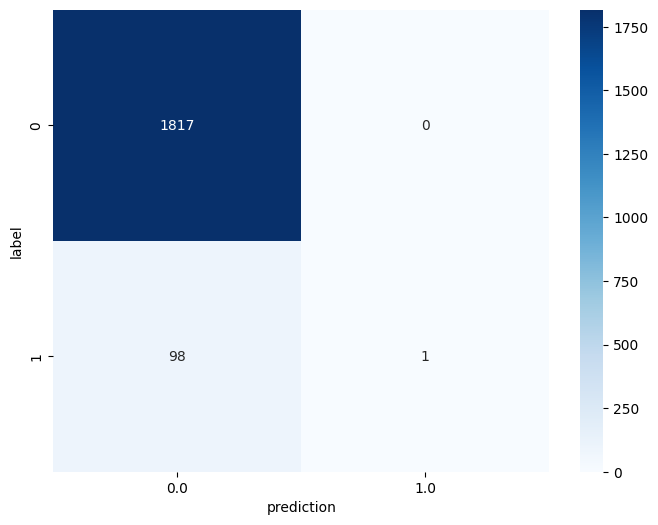

✓ Matriz generada y guardada.

🚀 Convirtiendo a ONNX...


[2026-01-02T15:05:52.516120Z] {tree_helper.py:285} INFO - [convert_decision_tree_classifier] in_set_rules has 0 elements
[2026-01-02T15:05:52.517704Z] {tree_helper.py:291} INFO - [convert_decision_tree_classifier] Node.create
[2026-01-02T15:05:52.519493Z] {tree_helper.py:293} INFO - [convert_decision_tree_classifier] unfold_rule_or
[2026-01-02T15:05:52.520138Z] {tree_helper.py:295} INFO - [convert_decision_tree_classifier] to_attrs
[2026-01-02T15:05:52.521484Z] {tree_helper.py:317} INFO - [convert_decision_tree_classifier] n_nodes=143
[2026-01-02T15:05:52.522225Z] {tree_helper.py:320} INFO - [convert_decision_tree_classifier] end
[2026-01-02T15:05:52.984559Z] {tree_helper.py:285} INFO - [convert_decision_tree_classifier] in_set_rules has 0 elements
[2026-01-02T15:05:52.985949Z] {tree_helper.py:291} INFO - [convert_decision_tree_classifier] Node.create
[2026-01-02T15:05:52.988378Z] {tree_helper.py:293} INFO - [convert_decision_tree_classifier] unfold_rule_or
[2026-01-02T15:05:52.989375Z

✓ Modelo ONNX guardado exitosamente.


In [76]:
import onnxruntime # Importamos para verificar que existe
from pyspark.sql import SparkSession
import mlflow.onnx

def fix_and_run_tests(model, test_df, feature_names, run_id):
    global spark
    
    # Asegurar que Spark esté activo
    spark = SparkSession.builder.getOrCreate()
    
    print(f"\n[Reintento] Procesando Run: {run_id}")
    
    with mlflow.start_run(run_id=run_id):
        
        # --- 1. Matriz de Confusión ---
        try:
            print("📊 Generando Matriz de Confusión...")
            # Forzamos un cache para asegurar que los datos estén disponibles
            test_df.cache() 
            predictions = model.transform(test_df)
            
            # El error ocurría aquí; ahora Spark está garantizado
            conf_data = predictions.groupBy('label', 'prediction').count().toPandas()
            
            if not conf_data.empty:
                conf_matrix = conf_data.pivot(index='label', columns='prediction', values='count').fillna(0)
                plt.figure(figsize=(8, 6))
                sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
                plt.savefig("confusion_matrix_fixed.png")
                mlflow.log_artifact("confusion_matrix_fixed.png", artifact_path="plots")
                plt.show()
                print("✓ Matriz generada y guardada.")
        except Exception as e:
            print(f"❌ Error en Matriz: {e}")

        # --- 2. Exportar a ONNX ---
        try:
            print("\n🚀 Convirtiendo a ONNX...")
            num_features = len(feature_names)
            initial_types = [('features', FloatTensorType([None, num_features]))]
            
            onnx_model = convert_sparkml(model, "SparkFraudModel", initial_types, spark_session=spark)
            
            # Ahora con onnxruntime instalado, esto no fallará
            mlflow.onnx.log_model(onnx_model, "model_onnx")
            
            with open("fraud_model_final.onnx", "wb") as f:
                f.write(onnx_model.SerializeToString())
            print("✓ Modelo ONNX guardado exitosamente.")
            
        except Exception as e:
            print(f"❌ Error en ONNX: {e}")

# Ejecutar
fix_and_run_tests(model, test_df, feature_names, run_id)


[Extras] Iniciando pruebas visuales y exportación ONNX para el Run: ddef4a8bcb414e55859f0b67fefdc275
📊 Generando gráfico de Matriz de Confusión...


26/01/02 10:06:36 WARN DAGScheduler: Broadcasting large task binary with size 1830.2 KiB
26/01/02 10:06:36 WARN DAGScheduler: Broadcasting large task binary with size 1745.5 KiB


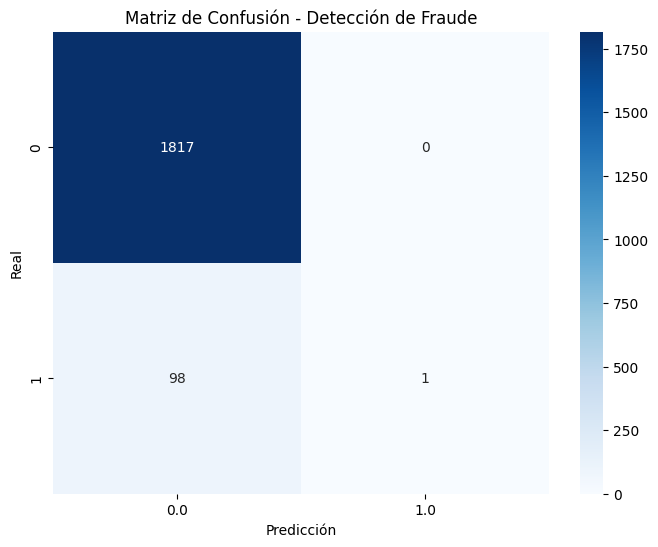

✓ Gráfico guardado en MLflow bajo la carpeta 'plots/'

🚀 Convirtiendo modelo Spark ML a ONNX...


[2026-01-02T15:06:37.189313Z] {tree_helper.py:285} INFO - [convert_decision_tree_classifier] in_set_rules has 0 elements
[2026-01-02T15:06:37.190707Z] {tree_helper.py:291} INFO - [convert_decision_tree_classifier] Node.create
[2026-01-02T15:06:37.192557Z] {tree_helper.py:293} INFO - [convert_decision_tree_classifier] unfold_rule_or
[2026-01-02T15:06:37.193464Z] {tree_helper.py:295} INFO - [convert_decision_tree_classifier] to_attrs
[2026-01-02T15:06:37.195412Z] {tree_helper.py:317} INFO - [convert_decision_tree_classifier] n_nodes=143
[2026-01-02T15:06:37.195823Z] {tree_helper.py:320} INFO - [convert_decision_tree_classifier] end
[2026-01-02T15:06:37.753657Z] {tree_helper.py:285} INFO - [convert_decision_tree_classifier] in_set_rules has 0 elements
[2026-01-02T15:06:37.754700Z] {tree_helper.py:291} INFO - [convert_decision_tree_classifier] Node.create
[2026-01-02T15:06:37.757009Z] {tree_helper.py:293} INFO - [convert_decision_tree_classifier] unfold_rule_or
[2026-01-02T15:06:37.758099Z

✓ Modelo exportado exitosamente como 'fraud_model.onnx'
✓ Modelo ONNX registrado en la UI de MLflow


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mlflow.onnx
import os
from pyspark.sql import SparkSession
from onnxmltools import convert_sparkml
from onnxmltools.convert.common.data_types import FloatTensorType

def run_advanced_tests(model, test_df, feature_names, run_id):
    """
    Pruebas visuales y exportación ONNX con validación de Spark Session.
    """
    # --- BLOQUE DE SEGURIDAD: REINICIAR SPARK SI ES NECESARIO ---
    global spark
    try:
        # Intentamos acceder al contexto. Si falla, entrará al except.
        if 'spark' not in globals() or spark._jsc is None:
            raise AttributeError
    except (AttributeError, NameError):
        print("⚠ Spark Session inactiva. Reiniciando conexión...")
        spark = SparkSession.builder \
            .appName("Airflow-MLflow-Pipeline") \
            .master("local[*]") \
            .getOrCreate()
    
    print(f"\n[Extras] Iniciando pruebas visuales y exportación ONNX para el Run: {run_id}")
    
    # Reabrimos el run de MLflow existente
    with mlflow.start_run(run_id=run_id):
        
        # --- 1. Generar Matriz de Confusión con Seaborn ---
        print("📊 Generando gráfico de Matriz de Confusión...")
        try:
            predictions = model.transform(test_df)
            # .toPandas() requiere que Spark esté activo
            conf_data = predictions.groupBy('label', 'prediction').count().toPandas()
            
            # Pivotar para el heatmap
            conf_matrix = conf_data.pivot(index='label', columns='prediction', values='count').fillna(0)
            
            plt.figure(figsize=(8, 6))
            sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
            plt.title('Matriz de Confusión - Detección de Fraude')
            plt.xlabel('Predicción')
            plt.ylabel('Real')
            
            # Guardar y registrar imagen en MLflow
            plot_path = "confusion_matrix.png"
            plt.savefig(plot_path)
            mlflow.log_artifact(plot_path, artifact_path="plots")
            plt.show()
            # 3. La envías a MLflow
            print(f"✓ Gráfico guardado en MLflow bajo la carpeta 'plots/'")
        except Exception as e:
            print(f"❌ Error al generar la matriz (posiblemente falta de datos o sesión): {e}")

        # --- 2. Exportar Modelo a ONNX ---
        print("\n🚀 Convirtiendo modelo Spark ML a ONNX...")
        num_features = len(feature_names)
        initial_types = [('features', FloatTensorType([None, num_features]))]
        
        try:
            # Convertir el modelo entrenado usando la sesión activa
            onnx_model = convert_sparkml(
                model, 
                "SparkFraudModel", 
                initial_types, 
                spark_session=spark
            )
            
            # Registrar el modelo ONNX en MLflow
            mlflow.onnx.log_model(onnx_model, "model_onnx")
            
            # Guardar archivo local
            onnx_path = "fraud_model.onnx"
            with open(onnx_path, "wb") as f:
                f.write(onnx_model.SerializeToString())
                
            print(f"✓ Modelo exportado exitosamente como '{onnx_path}'")
            print("✓ Modelo ONNX registrado en la UI de MLflow")
            
        except Exception as e:
            print(f"❌ Error en la conversión ONNX: {e}")
            print("Nota: Asegúrate de tener instalado 'onnxmltools' y 'onnxconverter-common'")

# Ejecutar las pruebas
# Asegúrate de que 'model' y 'test_df' sigan en memoria. 
# Si reiniciaste el kernel, deberás correr la celda de entrenamiento antes.
run_advanced_tests(model, test_df, feature_names, run_id)

## 6. Task 3: Feature Engineering

In [78]:
def feature_engineering(df):
    """Task 3: Preparación de features para ML"""
    print("[Task 3] Iniciando feature engineering...")
    
    # Indexar variables categóricas
    indexer = StringIndexer(inputCol='merchant_category', outputCol='merchant_category_idx')
    df_indexed = indexer.fit(df).transform(df)
    
    # Seleccionar features para el modelo
    feature_cols = [
        'amount_log',
        'merchant_category_idx',
        'transaction_hour',
        'customer_age',
        'is_international',
        'num_previous_transactions',
        'is_night_transaction',
        'is_large_amount',
        'risk_score'
    ]
    
    # Ensamblar features en vector
    assembler = VectorAssembler(inputCols=feature_cols, outputCol='features_raw')
    df_assembled = assembler.transform(df_indexed)
    
    # Escalar features
    scaler = StandardScaler(inputCol='features_raw', outputCol='features', withMean=True, withStd=True)
    scaler_model = scaler.fit(df_assembled)
    df_final = scaler_model.transform(df_assembled)
    
    # Seleccionar columnas finales
    df_ml = df_final.select('features', col('is_fraud').alias('label'))
    
    print(f"✓ Features creadas: {len(feature_cols)}")
    print(f"✓ Features: {feature_cols}")
    
    return df_ml, feature_cols

# Ejecutar Task 3
ml_df, feature_names = feature_engineering(transformed_df)
ml_df.show(5, truncate=False)

[Task 3] Iniciando feature engineering...


✓ Features creadas: 9
✓ Features: ['amount_log', 'merchant_category_idx', 'transaction_hour', 'customer_age', 'is_international', 'num_previous_transactions', 'is_night_transaction', 'is_large_amount', 'risk_score']
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                                               |label|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|[-0.15969256268762388,-0.43663615167760406,1.3789010095545806,-1.3334818522457834,-0.3309041203901173,-0.3587447393853113,-0.5797846501185545,-0.07436305704712297,-0.6292641275134397]|0    |
|[1.405010084272

## 7. Task 4: Entrenamiento de Modelo con MLflow

In [79]:
def train_model(df, feature_names):
    """Task 4: Entrenamiento de modelo con tracking en MLflow"""
    print("[Task 4] Iniciando entrenamiento de modelo...")
    
    # Split train/test
    train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
    
    print(f"✓ Training set: {train_df.count()} registros")
    print(f"✓ Test set: {test_df.count()} registros")
    
    # Iniciar MLflow run
    with mlflow.start_run(run_name="random-forest-fraud-detection") as run:
        
        # Log parámetros
        params = {
            'model_type': 'RandomForest',
            'num_trees': 100,
            'max_depth': 10,
            'feature_subset_strategy': 'auto'
        }
        mlflow.log_params(params)
        
        # Entrenar modelo
        rf = RandomForestClassifier(
            featuresCol='features',
            labelCol='label',
            numTrees=params['num_trees'],
            maxDepth=params['max_depth'],
            featureSubsetStrategy=params['feature_subset_strategy'],
            seed=42
        )
        
        print("\n⏳ Entrenando Random Forest...")
        model = rf.fit(train_df)
        print("✓ Modelo entrenado")
        
        # Feature importance
        feature_importance = list(zip(feature_names, model.featureImportances.toArray()))
        feature_importance.sort(key=lambda x: x[1], reverse=True)
        
        print("\n📊 Top 5 Features más importantes:")
        for feat, importance in feature_importance[:5]:
            print(f"  - {feat}: {importance:.4f}")
            mlflow.log_metric(f"feature_importance_{feat}", importance)
        
        # Guardar modelo
        mlflow.spark.log_model(model, "random-forest-model")
        
        # Log artifacts adicionales
        mlflow.log_param("num_features", len(feature_names))
        mlflow.set_tag("pipeline_stage", "training")
        mlflow.set_tag("framework", "spark-ml")
        
        print(f"\n✓ Run ID: {run.info.run_id}")
        
        return model, train_df, test_df, run.info.run_id

# Ejecutar Task 4
model, train_df, test_df, run_id = train_model(ml_df, feature_names)

[Task 4] Iniciando entrenamiento de modelo...


✓ Training set: 8079 registros
✓ Test set: 1921 registros

⏳ Entrenando Random Forest...


26/01/02 10:07:34 WARN DAGScheduler: Broadcasting large task binary with size 1143.6 KiB
26/01/02 10:07:34 WARN DAGScheduler: Broadcasting large task binary with size 1721.0 KiB
26/01/02 10:07:35 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
26/01/02 10:07:36 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


✓ Modelo entrenado

📊 Top 5 Features más importantes:
  - amount_log: 0.2356
  - customer_age: 0.2251
  - num_previous_transactions: 0.2140
  - transaction_hour: 0.1634
  - merchant_category_idx: 0.0907



✓ Run ID: f29ba8e38bcf478a9e69c6aab8989d6c


## 8. Task 5: Evaluación del Modelo

In [80]:
def evaluate_model(model, test_df, run_id):
    """Task 5: Evaluación del modelo y logging de métricas"""
    print("[Task 5] Iniciando evaluación del modelo...")
    
    # Predicciones
    predictions = model.transform(test_df)
    
    # Continuar el run anterior
    with mlflow.start_run(run_id=run_id):
        
        # Evaluadores
        binary_evaluator = BinaryClassificationEvaluator(
            labelCol='label',
            rawPredictionCol='rawPrediction',
            metricName='areaUnderROC'
        )
        
        multiclass_evaluator = MulticlassClassificationEvaluator(
            labelCol='label',
            predictionCol='prediction'
        )
        
        # Calcular métricas
        auc = binary_evaluator.evaluate(predictions)
        accuracy = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "accuracy"})
        precision = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "weightedPrecision"})
        recall = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "weightedRecall"})
        f1 = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "f1"})
        
        # Log métricas
        metrics = {
            'test_auc': auc,
            'test_accuracy': accuracy,
            'test_precision': precision,
            'test_recall': recall,
            'test_f1': f1
        }
        
        mlflow.log_metrics(metrics)
        
        # Mostrar resultados
        print("\n📊 Métricas del Modelo:")
        print(f"  • AUC-ROC: {auc:.4f}")
        print(f"  • Accuracy: {accuracy:.4f}")
        print(f"  • Precision: {precision:.4f}")
        print(f"  • Recall: {recall:.4f}")
        print(f"  • F1-Score: {f1:.4f}")
        
        # Matriz de confusión (simplificada)
        confusion = predictions.groupBy('label', 'prediction').count().toPandas()
        print("\n📊 Matriz de Confusión:")
        print(confusion)
        
        # Ejemplos de predicciones
        print("\n🔍 Ejemplos de Predicciones:")
        predictions.select('label', 'prediction', 'probability').show(10, truncate=False)
        
        return metrics

# Ejecutar Task 5
metrics = evaluate_model(model, test_df, run_id)

[Task 5] Iniciando evaluación del modelo...


26/01/02 10:07:57 WARN DAGScheduler: Broadcasting large task binary with size 1809.6 KiB
26/01/02 10:07:58 WARN DAGScheduler: Broadcasting large task binary with size 1821.4 KiB
26/01/02 10:07:59 WARN DAGScheduler: Broadcasting large task binary with size 1821.4 KiB
26/01/02 10:08:00 WARN DAGScheduler: Broadcasting large task binary with size 1821.4 KiB
26/01/02 10:08:01 WARN DAGScheduler: Broadcasting large task binary with size 1821.4 KiB



📊 Métricas del Modelo:
  • AUC-ROC: 0.5343
  • Accuracy: 0.9568
  • Precision: 0.9155
  • Recall: 0.9568
  • F1-Score: 0.9357


26/01/02 10:08:02 WARN DAGScheduler: Broadcasting large task binary with size 1818.6 KiB
26/01/02 10:08:02 WARN DAGScheduler: Broadcasting large task binary with size 1795.4 KiB



📊 Matriz de Confusión:
   label  prediction  count
0      0         0.0   1838
1      1         0.0     83

🔍 Ejemplos de Predicciones:
+-----+----------+-----------------------------------------+
|label|prediction|probability                              |
+-----+----------+-----------------------------------------+
|0    |0.0       |[0.9712593081548208,0.02874069184517923] |
|0    |0.0       |[0.9228567913682539,0.07714320863174604] |
|0    |0.0       |[0.9603872930378937,0.039612706962106364]|
|0    |0.0       |[0.9567380789407823,0.04326192105921765] |
|1    |0.0       |[0.9360700893260228,0.06392991067397724] |
|0    |0.0       |[0.953769587542873,0.04623041245712701]  |
|0    |0.0       |[0.9789206772497198,0.021079322750280242]|
|0    |0.0       |[0.9640293762722232,0.035970623727776846]|
|0    |0.0       |[0.9641473306535767,0.03585266934642332] |
|0    |0.0       |[0.9690367234614383,0.030963276538561676]|
+-----+----------+-----------------------------------------+
only show

26/01/02 10:08:03 WARN DAGScheduler: Broadcasting large task binary with size 1812.0 KiB


## 9. Resumen del Pipeline

In [81]:
print("="*70)
print("RESUMEN DEL PIPELINE SPARK + AIRFLOW + MLFLOW")
print("="*70)

print("\n✅ Tasks Completadas:")
print("  1. ✓ Ingesta de datos (Spark)")
print("  2. ✓ Transformación de datos (Spark)")
print("  3. ✓ Feature Engineering (Spark ML)")
print("  4. ✓ Entrenamiento de modelo (Random Forest)")
print("  5. ✓ Evaluación y registro (MLflow)")

print("\n📊 Métricas Finales:")
for metric, value in metrics.items():
    print(f"  • {metric}: {value:.4f}")

print("\n🔗 MLflow Tracking:")
print(f"  • Run ID: {run_id}")
print(f"  • Tracking URI: {mlflow.get_tracking_uri()}")
print(f"  • Experiment: spark-airflow-pipeline")

print("\n💡 Próximos Pasos:")
print("  1. Implementar el DAG completo en Airflow")
print("  2. Configurar scheduling automático (daily, hourly, etc.)")
print("  3. Añadir alertas y monitoring")
print("  4. Deploy del modelo en producción")
print("  5. Implementar retraining automático")

print("\n" + "="*70)

RESUMEN DEL PIPELINE SPARK + AIRFLOW + MLFLOW

✅ Tasks Completadas:
  1. ✓ Ingesta de datos (Spark)
  2. ✓ Transformación de datos (Spark)
  3. ✓ Feature Engineering (Spark ML)
  4. ✓ Entrenamiento de modelo (Random Forest)
  5. ✓ Evaluación y registro (MLflow)

📊 Métricas Finales:
  • test_auc: 0.5343
  • test_accuracy: 0.9568
  • test_precision: 0.9155
  • test_recall: 0.9568
  • test_f1: 0.9357

🔗 MLflow Tracking:
  • Run ID: f29ba8e38bcf478a9e69c6aab8989d6c
  • Tracking URI: file:///Users/yusefgonzalez/proyectos/arquitecturas/spark/notebooks/mlruns
  • Experiment: spark-airflow-pipeline

💡 Próximos Pasos:
  1. Implementar el DAG completo en Airflow
  2. Configurar scheduling automático (daily, hourly, etc.)
  3. Añadir alertas y monitoring
  4. Deploy del modelo en producción
  5. Implementar retraining automático



## 10. Archivo DAG para Airflow (Código de Producción)

Este código debería ir en `airflow/dags/spark_ml_pipeline.py`:

In [82]:
# Código de ejemplo para airflow/dags/spark_ml_pipeline.py

dag_code = '''
from airflow import DAG
from airflow.operators.python import PythonOperator
from airflow.providers.apache.spark.operators.spark_submit import SparkSubmitOperator
from datetime import datetime, timedelta

default_args = {
    'owner': 'yusef',
    'depends_on_past': False,
    'start_date': datetime(2024, 1, 1),
    'email': ['yusef@example.com'],
    'email_on_failure': True,
    'email_on_retry': False,
    'retries': 2,
    'retry_delay': timedelta(minutes=5),
}

dag = DAG(
    'spark_ml_pipeline',
    default_args=default_args,
    description='Pipeline ML con Spark y MLflow',
    schedule_interval='@daily',  # Ejecutar diariamente
    catchup=False,
    tags=['spark', 'ml', 'mlflow'],
)

# Task 1: Ingesta
ingest_task = SparkSubmitOperator(
    task_id='ingest_data',
    application='scripts/ingest_data.py',
    conn_id='spark_default',
    dag=dag,
)

# Task 2: Transformación
transform_task = SparkSubmitOperator(
    task_id='transform_data',
    application='scripts/transform_data.py',
    conn_id='spark_default',
    dag=dag,
)

# Task 3: Feature Engineering
feature_task = SparkSubmitOperator(
    task_id='feature_engineering',
    application='scripts/feature_engineering.py',
    conn_id='spark_default',
    dag=dag,
)

# Task 4: Training
train_task = SparkSubmitOperator(
    task_id='train_model',
    application='scripts/train_model.py',
    conn_id='spark_default',
    dag=dag,
)

# Task 5: Evaluation
eval_task = PythonOperator(
    task_id='evaluate_model',
    python_callable=evaluate_model_func,
    dag=dag,
)

# Definir dependencias
ingest_task >> transform_task >> feature_task >> train_task >> eval_task
'''

print("Código del DAG para Airflow:")
print(dag_code)

# Guardar a archivo
with open('../scripts/example_airflow_dag.py', 'w') as f:
    f.write(dag_code)
    
print("\n✓ DAG guardado en: scripts/example_airflow_dag.py")

Código del DAG para Airflow:

from airflow import DAG
from airflow.operators.python import PythonOperator
from airflow.providers.apache.spark.operators.spark_submit import SparkSubmitOperator
from datetime import datetime, timedelta

default_args = {
    'owner': 'yusef',
    'depends_on_past': False,
    'start_date': datetime(2024, 1, 1),
    'email': ['yusef@example.com'],
    'email_on_failure': True,
    'email_on_retry': False,
    'retries': 2,
    'retry_delay': timedelta(minutes=5),
}

dag = DAG(
    'spark_ml_pipeline',
    default_args=default_args,
    description='Pipeline ML con Spark y MLflow',
    schedule_interval='@daily',  # Ejecutar diariamente
    catchup=False,
    tags=['spark', 'ml', 'mlflow'],
)

# Task 1: Ingesta
ingest_task = SparkSubmitOperator(
    task_id='ingest_data',
    application='scripts/ingest_data.py',
    conn_id='spark_default',
    dag=dag,
)

# Task 2: Transformación
transform_task = SparkSubmitOperator(
    task_id='transform_data',
    appli

## 11. Cleanup

In [83]:
# Cerrar sesión de Spark
#spark.stop()
# print("✓ Spark session cerrada")

## Conclusiones

### Aprendizajes Clave

1. **Integración Spark + Airflow + MLflow**
   - Airflow orquesta las tareas del pipeline
   - Spark procesa datos a escala
   - MLflow trackea experimentos y modelos

2. **Pipeline End-to-End**
   - Ingesta → Transformación → Feature Engineering → Training → Evaluation
   - Cada etapa es modular e independiente
   - Fácil de escalar y mantener

3. **Ventajas**
   - ✅ Reproducibilidad (MLflow)
   - ✅ Escalabilidad (Spark)
   - ✅ Automatización (Airflow)
   - ✅ Monitoreo centralizado

### Recursos Adicionales

- [Airflow Documentation](https://airflow.apache.org/)
- [Spark ML Guide](https://spark.apache.org/docs/latest/ml-guide.html)
- [MLflow Tracking](https://mlflow.org/docs/latest/tracking.html)

### Ejercicios Propuestos

1. Modificar el pipeline para usar otros algoritmos (GBT, SVM)
2. Implementar hyperparameter tuning con CrossValidator
3. Añadir data validation con Great Expectations
4. Crear alertas en Airflow para fallos del modelo
5. Deploy del modelo usando MLflow Model Registry